# Preparations

In [1]:
!pip install stepmix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 136.8 kB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# show all cols in df
pd.set_option('display.max_columns', None)

# Function to do all the preprocessing

def preprocess_train_test(train_df, test_df):
    def preprocess_single(df):
        df_copy = df.copy()

        # Ensure 'trans_date_trans_time' is in datetime format
        df_copy['trans_date_trans_time'] = pd.to_datetime(df_copy['trans_date_trans_time'])
        df_copy['unix_time'] = pd.to_datetime(df_copy['unix_time'], unit='s')

        # Get month of year, day of week, and hour of day for transactions
        df_copy['trans_day_of_week'] = df_copy['trans_date_trans_time'].dt.day_name()
        df_copy['trans_month'] = df_copy['trans_date_trans_time'].dt.month_name()

        # Create 'time_of_day' column
        df_copy['time_of_day'] = (df_copy['trans_date_trans_time'].dt.hour * 60 + df_copy['trans_date_trans_time'].dt.minute) / (24 * 60)

        # Calculate age in years
        df_copy['dob'] = pd.to_datetime(df_copy['dob'])
        df_copy['age'] = df_copy['trans_date_trans_time'].dt.year - df_copy['dob'].dt.year - (
            (df_copy['trans_date_trans_time'].dt.month < df_copy['dob'].dt.month) |
            ((df_copy['trans_date_trans_time'].dt.month == df_copy['dob'].dt.month) & (df_copy['trans_date_trans_time'].dt.day < df_copy['dob'].dt.day))
        )

        # Sort the DataFrame by 'cc_num' and 'trans_date_trans_time'
        df_copy.sort_values(by=['cc_num', 'trans_date_trans_time'], inplace=True)

        # Group by 'cc_num' and calculate the time difference
        df_copy['last_purchased'] = df_copy.groupby('cc_num')['trans_date_trans_time'].diff()

        # For the first transaction for each 'cc_num', set 'last_purchased' to NaT
        df_copy['last_purchased'] = df_copy['last_purchased'].fillna(pd.NaT)

        # Convert 'last_purchased' to numerical format (total number of seconds)
        df_copy['last_purchased_secs'] = df_copy['last_purchased'].dt.total_seconds()

        # Define the Haversine distance function
        def haversine(lat1, lon1, lat2, lon2):
            R = 6371  # Radius of the Earth in kilometers
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            dlat = lat2 - lat1
            dlon = lon2 - lon1
            a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
            return R * c

        # Calculate the distance to the last purchase
        df_copy['last_merch_lat'] = df_copy.groupby('cc_num')['merch_lat'].shift()
        df_copy['last_merch_long'] = df_copy.groupby('cc_num')['merch_long'].shift()

        df_copy['distance_last_purchase'] = haversine(df_copy['merch_lat'], df_copy['merch_long'], df_copy['last_merch_lat'], df_copy['last_merch_long'])

        # For the first transaction for each 'cc_num', set 'distance_last_purchase' to NaN
        df_copy['distance_last_purchase'] = df_copy['distance_last_purchase'].fillna(np.nan)

        # Create 'same_merchant_with_last_purchase' column
        df_copy['last_merchant'] = df_copy.groupby('cc_num')['merchant'].shift()
        df_copy['same_merchant_with_last_purchase'] = (df_copy['merchant'] == df_copy['last_merchant'])

        # Drop the temporary columns
        df_copy.drop(columns=['last_merch_lat', 'last_merch_long', 'last_merchant'], inplace=True)

        # Drop the specified columns
        df_copy.drop(columns=['last_purchased', 'city', 'street', 'last', 'first', 'job', 'cc_num', 'merchant', 'state', 'zip', 'lat', 'long', 'merch_lat', 'merch_long', 'trans_num', 'unix_time', 'dob'], inplace=True)

        # Sort the DataFrame by the original index to maintain the original order
        df_copy.sort_index(inplace=True)

        return df_copy

    train_df_preprocessed = preprocess_single(train_df)
    test_df_preprocessed = preprocess_single(test_df)

    return train_df_preprocessed, test_df_preprocessed

# Takes in processsed train and test data, removes all January 2019 data, and returns train, val, test
def process_fraud_data(train_df_preprocessed, test_df_preprocessed):
    # Combine the preprocessed data
    combined_df = pd.concat([train_df_preprocessed, test_df_preprocessed])

    # Remove rows where 'last_purchased_secs' is NaN
    combined_df = combined_df.dropna(subset=['last_purchased_secs'])

    # Remove all January 2019 data
    combined_df = combined_df[~((combined_df['trans_date_trans_time'].dt.year == 2019) & (combined_df['trans_date_trans_time'].dt.month == 1))]

    # Drop trans_date_trans_time
    combined_df = combined_df.drop(columns=['trans_date_trans_time'])

    # Split the combined data into train, validation, and test sets by order
    total_samples = len(combined_df)
    train_end = int(0.64 * total_samples)
    val_end = int(0.80 * total_samples)

    train_data = combined_df.iloc[:train_end]
    val_data = combined_df.iloc[train_end:val_end]
    test_data = combined_df.iloc[val_end:]

    return train_data, val_data, test_data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_df = pd.read_csv("/content/drive/Shared drives/Machine Learning/Project/fraudTrain.csv", index_col=0)
test_df = pd.read_csv("/content/drive/Shared drives/Machine Learning/Project/fraudTest.csv", index_col=0)
train_preprocessed, test_preprocessed = preprocess_train_test(train_df, test_df)
train, val, test = process_fraud_data(train_preprocessed, train_preprocessed)
train.head()

,category,amt,gender,city_pop,is_fraud,trans_day_of_week,trans_month,time_of_day,age,last_purchased_secs,distance_last_purchase,same_merchant_with_last_purchase
52525,grocery_net,19.46,F,1423,0,Friday,February,0.001389,20,16027.0,155.644412,False
52526,misc_net,13.01,M,471,0,Friday,February,0.002083,51,163101.0,121.187723,False
52527,gas_transport,50.02,M,471,0,Friday,February,0.003472,77,55381.0,28.230127,False
52528,entertainment,6.11,M,192805,0,Friday,February,0.004167,55,91351.0,132.898691,False
52529,grocery_net,32.14,M,18408,0,Friday,February,0.005556,46,971.0,81.694148,False


## Identify Variable Types

In [5]:
categorical_features = ['category', 'gender', 'trans_day_of_week', 'trans_month', 'same_merchant_with_last_purchase']
continuous_features = ['amt', "city_pop", "time_of_day", "age", 'last_purchased_secs', 'distance_last_purchase']

## Fraud Transaction Clustering

## LCA

## Make Continuous variables descret & One-hot encode categorical variables

In [6]:
train_fraud = train[train["is_fraud"]==1]
binning = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
train_fraud_lca_con = pd.DataFrame(binning.fit_transform(train_fraud[continuous_features]).astype(int),
                              columns=continuous_features,
                              index=train_fraud.index).astype(str) # Use the original DataFrame's index
#train_lca_con.columns = continuous_features # No longer needed
train_fraud_lca = pd.concat([train_fraud_lca_con, train_fraud[categorical_features]], axis=1)
train_fraud_lca = pd.get_dummies(train_fraud_lca).astype(int)

test_fraud = test[test["is_fraud"]==1]
test_fraud_lca_con = pd.DataFrame(binning.transform(test_fraud[continuous_features]).astype(int),
                              columns=continuous_features,
                              index=test_fraud.index).astype(str) # Use the original DataFrame'
test_fraud_lca = pd.concat([test_fraud_lca_con, test_fraud[categorical_features]], axis=1)
test_fraud_lca = pd.get_dummies(test_fraud_lca).astype(int)

# Ensure all columns of train are in test
test_fraud_lca = test_fraud_lca.reindex(columns=train_fraud_lca.columns, fill_value=0)

train_fraud_lca.head()

,same_merchant_with_last_purchase,amt_0,amt_1,amt_2,amt_3,city_pop_0,city_pop_1,city_pop_2,city_pop_3,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,age_0,age_1,age_2,age_3,last_purchased_secs_0,last_purchased_secs_1,last_purchased_secs_2,last_purchased_secs_3,distance_last_purchase_0,distance_last_purchase_1,distance_last_purchase_2,distance_last_purchase_3,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,trans_day_of_week_Friday,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday,trans_month_April,trans_month_August,trans_month_December,trans_month_February,trans_month_January,trans_month_July,trans_month_June,trans_month_March,trans_month_May,trans_month_November,trans_month_October,trans_month_September
52578,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52579,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52587,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52601,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
52613,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [16]:
#


In [7]:
test_fraud_lca.head()

,same_merchant_with_last_purchase,amt_0,amt_1,amt_2,amt_3,city_pop_0,city_pop_1,city_pop_2,city_pop_3,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,age_0,age_1,age_2,age_3,last_purchased_secs_0,last_purchased_secs_1,last_purchased_secs_2,last_purchased_secs_3,distance_last_purchase_0,distance_last_purchase_1,distance_last_purchase_2,distance_last_purchase_3,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,trans_day_of_week_Friday,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday,trans_month_April,trans_month_August,trans_month_December,trans_month_February,trans_month_January,trans_month_July,trans_month_June,trans_month_March,trans_month_May,trans_month_November,trans_month_October,trans_month_September
799088,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
799102,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
799156,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
799194,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
799233,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


## Fitting

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  4.34it/s, max_LL=-2.09e+5, max_avg_LL=-23.1]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'f

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, max_LL=-2.02e+5, max_avg_LL=-22.3]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'f

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.18it/s, max_LL=-1.97e+5, max_avg_LL=-21.7]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'f

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.21it/s, max_LL=-1.96e+5, max_avg_LL=-21.6]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'f

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, max_LL=-1.94e+5, max_avg_LL=-21.4]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


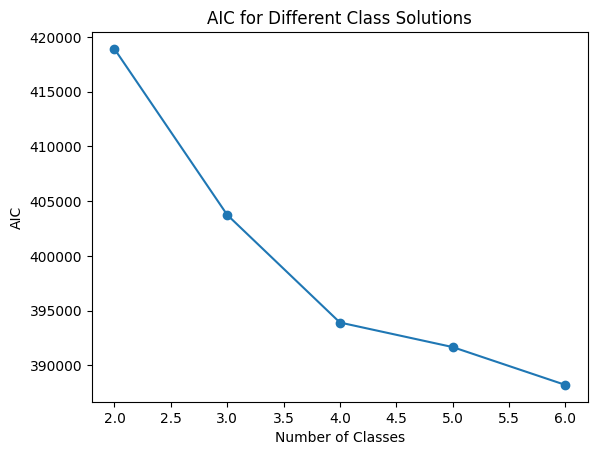

4


In [8]:
from stepmix.stepmix import StepMix
aic_values = []
models = []
K = 6 # picked arbitrarily
for n_classes in range(2, K+1):
    model = StepMix(n_components=n_classes, n_steps=1, random_state=42)
    model.fit(train_fraud_lca)
    aic_values.append(model.aic(train_fraud_lca))
    models.append(model)

# Step 4: Evaluate the Model
plt.plot(range(2, K+1), aic_values, marker='o')
plt.xlabel('Number of Classes')
plt.ylabel('AIC')
plt.title('AIC for Different Class Solutions')
plt.show()

# Select the best model based on lowest AIC (or maybe we should use elbow method)
print(aic_values.index(min(aic_values)))

# # Plot the marginal distribution of the classes
# class_labels = best_model.predict(train_fraud_lca)

# sns.countplot(class_labels)
# plt.title('Marginal Distribution of Classes')
# plt.show()

We use the elbow rule to pick for as the optimal cluster.

## Validations

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  5.51it/s, max_LL=-1.97e+5, max_avg_LL=-21.7]
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 14.43it/s, max_LL=-5.97e+4, max_avg_LL=-21.3]


Train Class Sizes: [0.24988958 0.25011042 0.25       0.25      ]
Test Class Sizes: [0.26159886 0.24946467 0.23162027 0.2573162 ]
Class Size Stability: True
Conditional Probability Stability: True


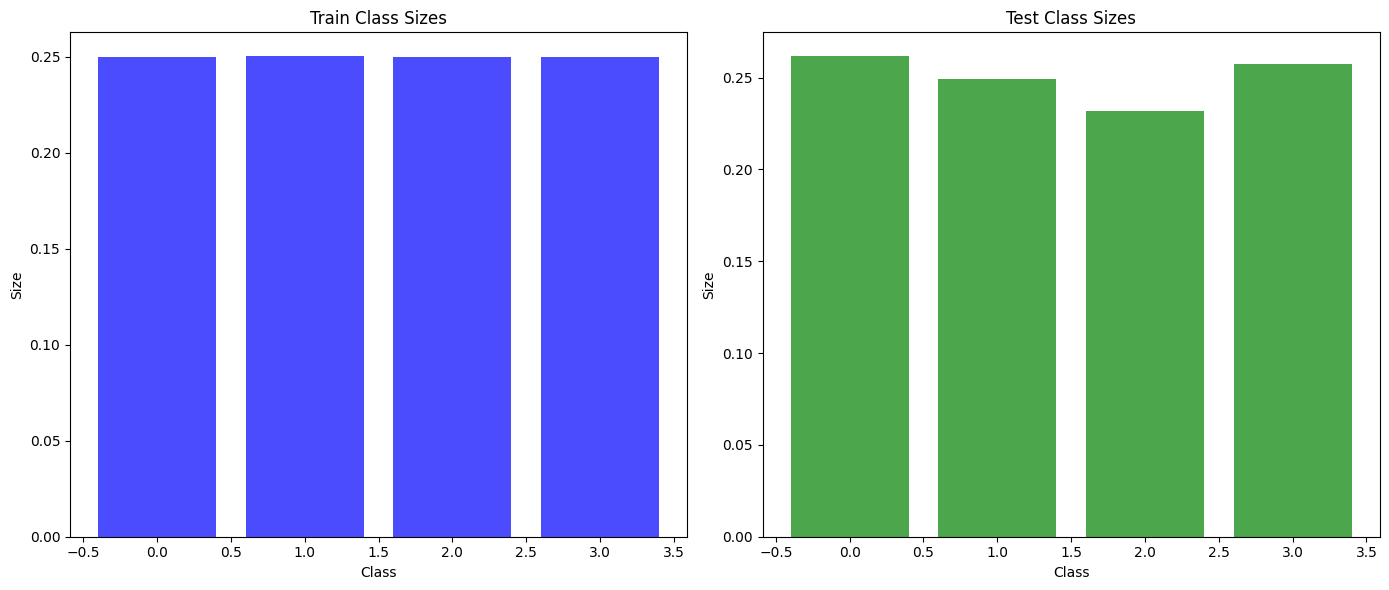

In [10]:
# Fit LCA Model on Training Data with Chosen K
chosen_k = 4

train_model = StepMix(n_components=chosen_k, n_steps=1, random_state=42)
train_model.fit(train_fraud_lca)
# Extract the class-conditional probabilities (probs) from the trained model
train_params = train_model.get_parameters()

# Fit LCA Model on Test Data Using Train Model Probabilities as Initialization
test_model = StepMix(n_components=chosen_k, n_steps=1, random_state=42)
# Set initial parameters using training model probabilities
test_model.set_parameters(train_params)
# Fit the model on test data
test_model.fit(test_fraud_lca)
# Extract the class-conditional probabilities and class sizes from test data
test_params = test_model.get_parameters()
test_probs = test_params["measurement"]
test_class_sizes = test_model.weights_

# Compare Stability - Similarity of Class Sizes and Conditional Probabilities
similarity_class_sizes = np.allclose(train_params["weights"], test_class_sizes, atol=0.05)
similarity_probs = all(
    np.allclose(train_params["measurement"][var], test_probs[var], atol=0.05) for var in train_params["measurement"]
)

results = {
    "Train Class Sizes": train_params["weights"],
    "Test Class Sizes": test_class_sizes,
    "Class Size Stability": similarity_class_sizes,
    "Conditional Probability Stability": similarity_probs
}

print("Train Class Sizes:", train_params["weights"])
print("Test Class Sizes:", test_class_sizes)
print("Class Size Stability:", similarity_class_sizes)
print("Conditional Probability Stability:", similarity_probs)

# Plot class sizes for train and test models separately
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(range(chosen_k), train_params["weights"], alpha=0.7, color='blue')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Size')
axes[0].set_title('Train Class Sizes')

axes[1].bar(range(chosen_k), test_class_sizes, alpha=0.7, color='green')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Size')
axes[1].set_title('Test Class Sizes')

plt.tight_layout()
plt.show()

In [12]:
# prompt: save the trained model

import pickle

# Save the best model to a file
filename = '/content/drive/Shared drives/Machine Learning/Project/final_models/lca_model.sav'
pickle.dump(train_model, open(filename, 'wb'))

In [13]:
# load lca model
import pickle
filename = '/content/drive/Shared drives/Machine Learning/Project/final_models/lca_model.sav'
train_model = pickle.load(open(filename, 'rb'))

In [14]:
# prompt: save test set cluster predicted by model

import pandas as pd
# Predict the clusters for the test set
test_clusters = train_model.predict(test_fraud_lca)

# Create a DataFrame with the cluster assignments
test_cluster_df = pd.DataFrame({'cluster': test_clusters}, index=test_fraud_lca.index)
test_cluster_df.head()


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,cluster
799088,1
799102,3
799156,2
799194,3
799233,0


In [15]:

# Save the cluster assignments to a CSV file
test_cluster_df.to_csv('/content/drive/Shared drives/Machine Learning/Project/test_set_clusters.csv')

In [ ]:
# load testset cluster
test_cluster_df = pd.read_csv('/content/drive/Shared drives/Machine Learning/Project/test_set_clusters.csv', index_col=0)

Cluster sizes are similar.

### Membership Probabilities

In [21]:
# Get class-conditional probabilities for each feature
parameters = train_model.get_parameters()

# Create a DataFrame to store class-conditional probabilities
class_probabilities = pd.DataFrame(parameters['measurement']["pis"])
class_probabilities.columns = train_fraud_lca.columns
class_probabilities

,same_merchant_with_last_purchase,amt_0,amt_1,amt_2,amt_3,city_pop_0,city_pop_1,city_pop_2,city_pop_3,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,age_0,age_1,age_2,age_3,last_purchased_secs_0,last_purchased_secs_1,last_purchased_secs_2,last_purchased_secs_3,distance_last_purchase_0,distance_last_purchase_1,distance_last_purchase_2,distance_last_purchase_3,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,trans_day_of_week_Friday,trans_day_of_week_Monday,trans_day_of_week_Saturday,trans_day_of_week_Sunday,trans_day_of_week_Thursday,trans_day_of_week_Tuesday,trans_day_of_week_Wednesday,trans_month_April,trans_month_August,trans_month_December,trans_month_February,trans_month_January,trans_month_July,trans_month_June,trans_month_March,trans_month_May,trans_month_November,trans_month_October,trans_month_September
0,0.000884,1.000000e-15,1.000000e+00,1.000000e-15,1.000000e-15,0.246133,0.270879,0.220504,0.262483,0.461335,0.312859,0.108705,0.117101,0.228900,0.237296,0.262483,0.271321,0.188688,0.265135,0.358374,0.187804,0.254529,0.248785,0.243040,0.253646,7.954043e-03,1.000000e-15,1.000000e-15,1.000000e-15,9.173663e-01,1.000000e-15,7.467963e-02,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,0.464870,0.535130,0.159081,0.160848,0.146266,0.153778,0.138312,0.125497,0.116217,0.131684,0.041096,0.060097,0.150685,0.041096,0.030490,0.114450,0.151127,0.137870,0.050817,0.045515,0.045073
1,0.001766,1.000000e-15,1.000000e-15,1.000000e+00,1.000000e-15,0.263576,0.256512,0.229581,0.250331,0.162914,0.210155,0.292274,0.334658,0.239294,0.252980,0.250773,0.256954,0.304194,0.245033,0.197792,0.252980,0.236645,0.261369,0.256954,0.245033,1.147903e-01,1.000000e-15,1.000000e-15,1.000000e-15,3.532009e-03,1.000000e-15,3.090508e-03,1.000000e-15,4.326711e-01,2.913907e-02,1.000000e-15,1.448124e-01,2.719647e-01,1.000000e-15,0.491391,0.508609,0.141280,0.154967,0.175717,0.159823,0.136424,0.122737,0.109051,0.115673,0.044150,0.069316,0.147903,0.038852,0.035762,0.122296,0.143929,0.143929,0.041501,0.050773,0.045916
2,0.002208,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e+00,0.225265,0.220406,0.296820,0.257509,0.081714,0.204505,0.373675,0.340106,0.257067,0.187279,0.261042,0.294611,0.291519,0.243816,0.169170,0.295495,0.249117,0.242933,0.253534,0.254417,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,5.256184e-02,3.533569e-03,1.000000e-15,7.694346e-01,1.744700e-01,1.000000e-15,0.436837,0.563163,0.157244,0.153269,0.152385,0.165194,0.137809,0.125000,0.109099,0.109099,0.040636,0.071555,0.154594,0.036661,0.044611,0.100265,0.148852,0.151502,0.039311,0.057862,0.045053
3,0.001767,1.000000e+00,1.000000e-15,1.000000e-15,1.000000e-15,0.264576,0.250442,0.253975,0.231007,0.291078,0.273410,0.208922,0.226590,0.265459,0.300795,0.233657,0.200088,0.215548,0.246025,0.274293,0.264134,0.259717,0.246908,0.246466,0.246908,1.000000e-15,7.906360e-02,3.330389e-01,7.287986e-02,1.000000e-15,7.641343e-02,2.340989e-02,1.289753e-01,1.000000e-15,1.042403e-01,1.196996e-01,1.000000e-15,1.000000e-15,6.227915e-02,0.598940,0.401060,0.139576,0.178004,0.181095,0.153269,0.121466,0.112191,0.114399,0.102032,0.041519,0.057420,0.143551,0.033569,0.034452,0.122350,0.179770,0.155919,0.038428,0.044611,0.046378


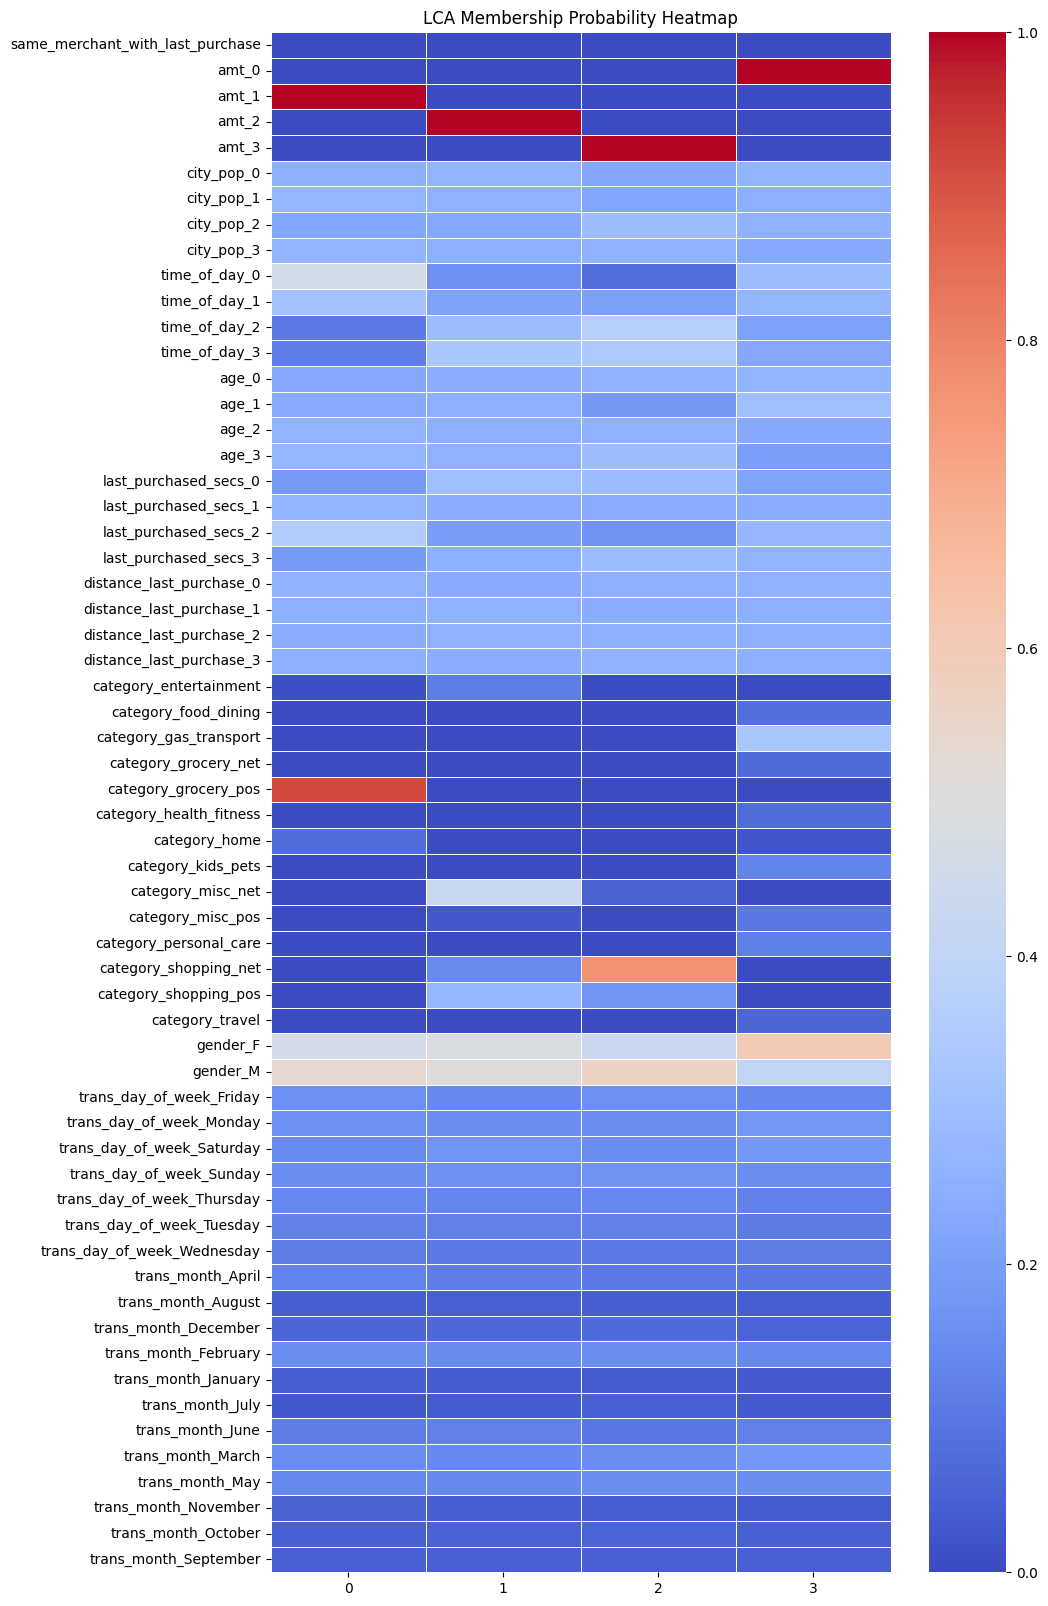

In [22]:
plt.figure(figsize=(10, 20))
sns.heatmap(class_probabilities.T, cmap="coolwarm", annot=False, linewidths=0.5)

# Set title
plt.title("LCA Membership Probability Heatmap")

# Show plot
plt.show()



In [23]:
cols = train_fraud_lca.columns.to_list()
not_interested = ["trans_month_September", "trans_month_October", "trans_month_November",
"trans_month_December", "trans_month_January", "trans_month_February", "trans_month_March",
"trans_month_April", "trans_month_May", "trans_month_June", "trans_month_July", "trans_month_August"] \
+ ["trans_day_of_week_Monday", "trans_day_of_week_Saturday", "trans_day_of_week_Sunday",
"trans_day_of_week_Thursday", "trans_day_of_week_Tuesday", "trans_day_of_week_Wednesday", "trans_day_of_week_Friday"] \

interested = [col for col in cols if col not in not_interested]
interested

['same_merchant_with_last_purchase',
 'amt_0',
 'amt_1',
 'amt_2',
 'amt_3',
 'city_pop_0',
 'city_pop_1',
 'city_pop_2',
 'city_pop_3',
 'time_of_day_0',
 'time_of_day_1',
 'time_of_day_2',
 'time_of_day_3',
 'age_0',
 'age_1',
 'age_2',
 'age_3',
 'last_purchased_secs_0',
 'last_purchased_secs_1',
 'last_purchased_secs_2',
 'last_purchased_secs_3',
 'distance_last_purchase_0',
 'distance_last_purchase_1',
 'distance_last_purchase_2',
 'distance_last_purchase_3',
 'category_entertainment',
 'category_food_dining',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel',
 'gender_F',
 'gender_M']

In [24]:
class_probabilities = pd.DataFrame(parameters['measurement']["pis"])
class_probabilities.columns = train_fraud_lca.columns
class_probabilities = class_probabilities[interested]
class_probabilities

,same_merchant_with_last_purchase,amt_0,amt_1,amt_2,amt_3,city_pop_0,city_pop_1,city_pop_2,city_pop_3,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3,age_0,age_1,age_2,age_3,last_purchased_secs_0,last_purchased_secs_1,last_purchased_secs_2,last_purchased_secs_3,distance_last_purchase_0,distance_last_purchase_1,distance_last_purchase_2,distance_last_purchase_3,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
0,0.000884,1.000000e-15,1.000000e+00,1.000000e-15,1.000000e-15,0.246133,0.270879,0.220504,0.262483,0.461335,0.312859,0.108705,0.117101,0.228900,0.237296,0.262483,0.271321,0.188688,0.265135,0.358374,0.187804,0.254529,0.248785,0.243040,0.253646,7.954043e-03,1.000000e-15,1.000000e-15,1.000000e-15,9.173663e-01,1.000000e-15,7.467963e-02,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,0.464870,0.535130
1,0.001766,1.000000e-15,1.000000e-15,1.000000e+00,1.000000e-15,0.263576,0.256512,0.229581,0.250331,0.162914,0.210155,0.292274,0.334658,0.239294,0.252980,0.250773,0.256954,0.304194,0.245033,0.197792,0.252980,0.236645,0.261369,0.256954,0.245033,1.147903e-01,1.000000e-15,1.000000e-15,1.000000e-15,3.532009e-03,1.000000e-15,3.090508e-03,1.000000e-15,4.326711e-01,2.913907e-02,1.000000e-15,1.448124e-01,2.719647e-01,1.000000e-15,0.491391,0.508609
2,0.002208,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e+00,0.225265,0.220406,0.296820,0.257509,0.081714,0.204505,0.373675,0.340106,0.257067,0.187279,0.261042,0.294611,0.291519,0.243816,0.169170,0.295495,0.249117,0.242933,0.253534,0.254417,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,5.256184e-02,3.533569e-03,1.000000e-15,7.694346e-01,1.744700e-01,1.000000e-15,0.436837,0.563163
3,0.001767,1.000000e+00,1.000000e-15,1.000000e-15,1.000000e-15,0.264576,0.250442,0.253975,0.231007,0.291078,0.273410,0.208922,0.226590,0.265459,0.300795,0.233657,0.200088,0.215548,0.246025,0.274293,0.264134,0.259717,0.246908,0.246466,0.246908,1.000000e-15,7.906360e-02,3.330389e-01,7.287986e-02,1.000000e-15,7.641343e-02,2.340989e-02,1.289753e-01,1.000000e-15,1.042403e-01,1.196996e-01,1.000000e-15,1.000000e-15,6.227915e-02,0.598940,0.401060


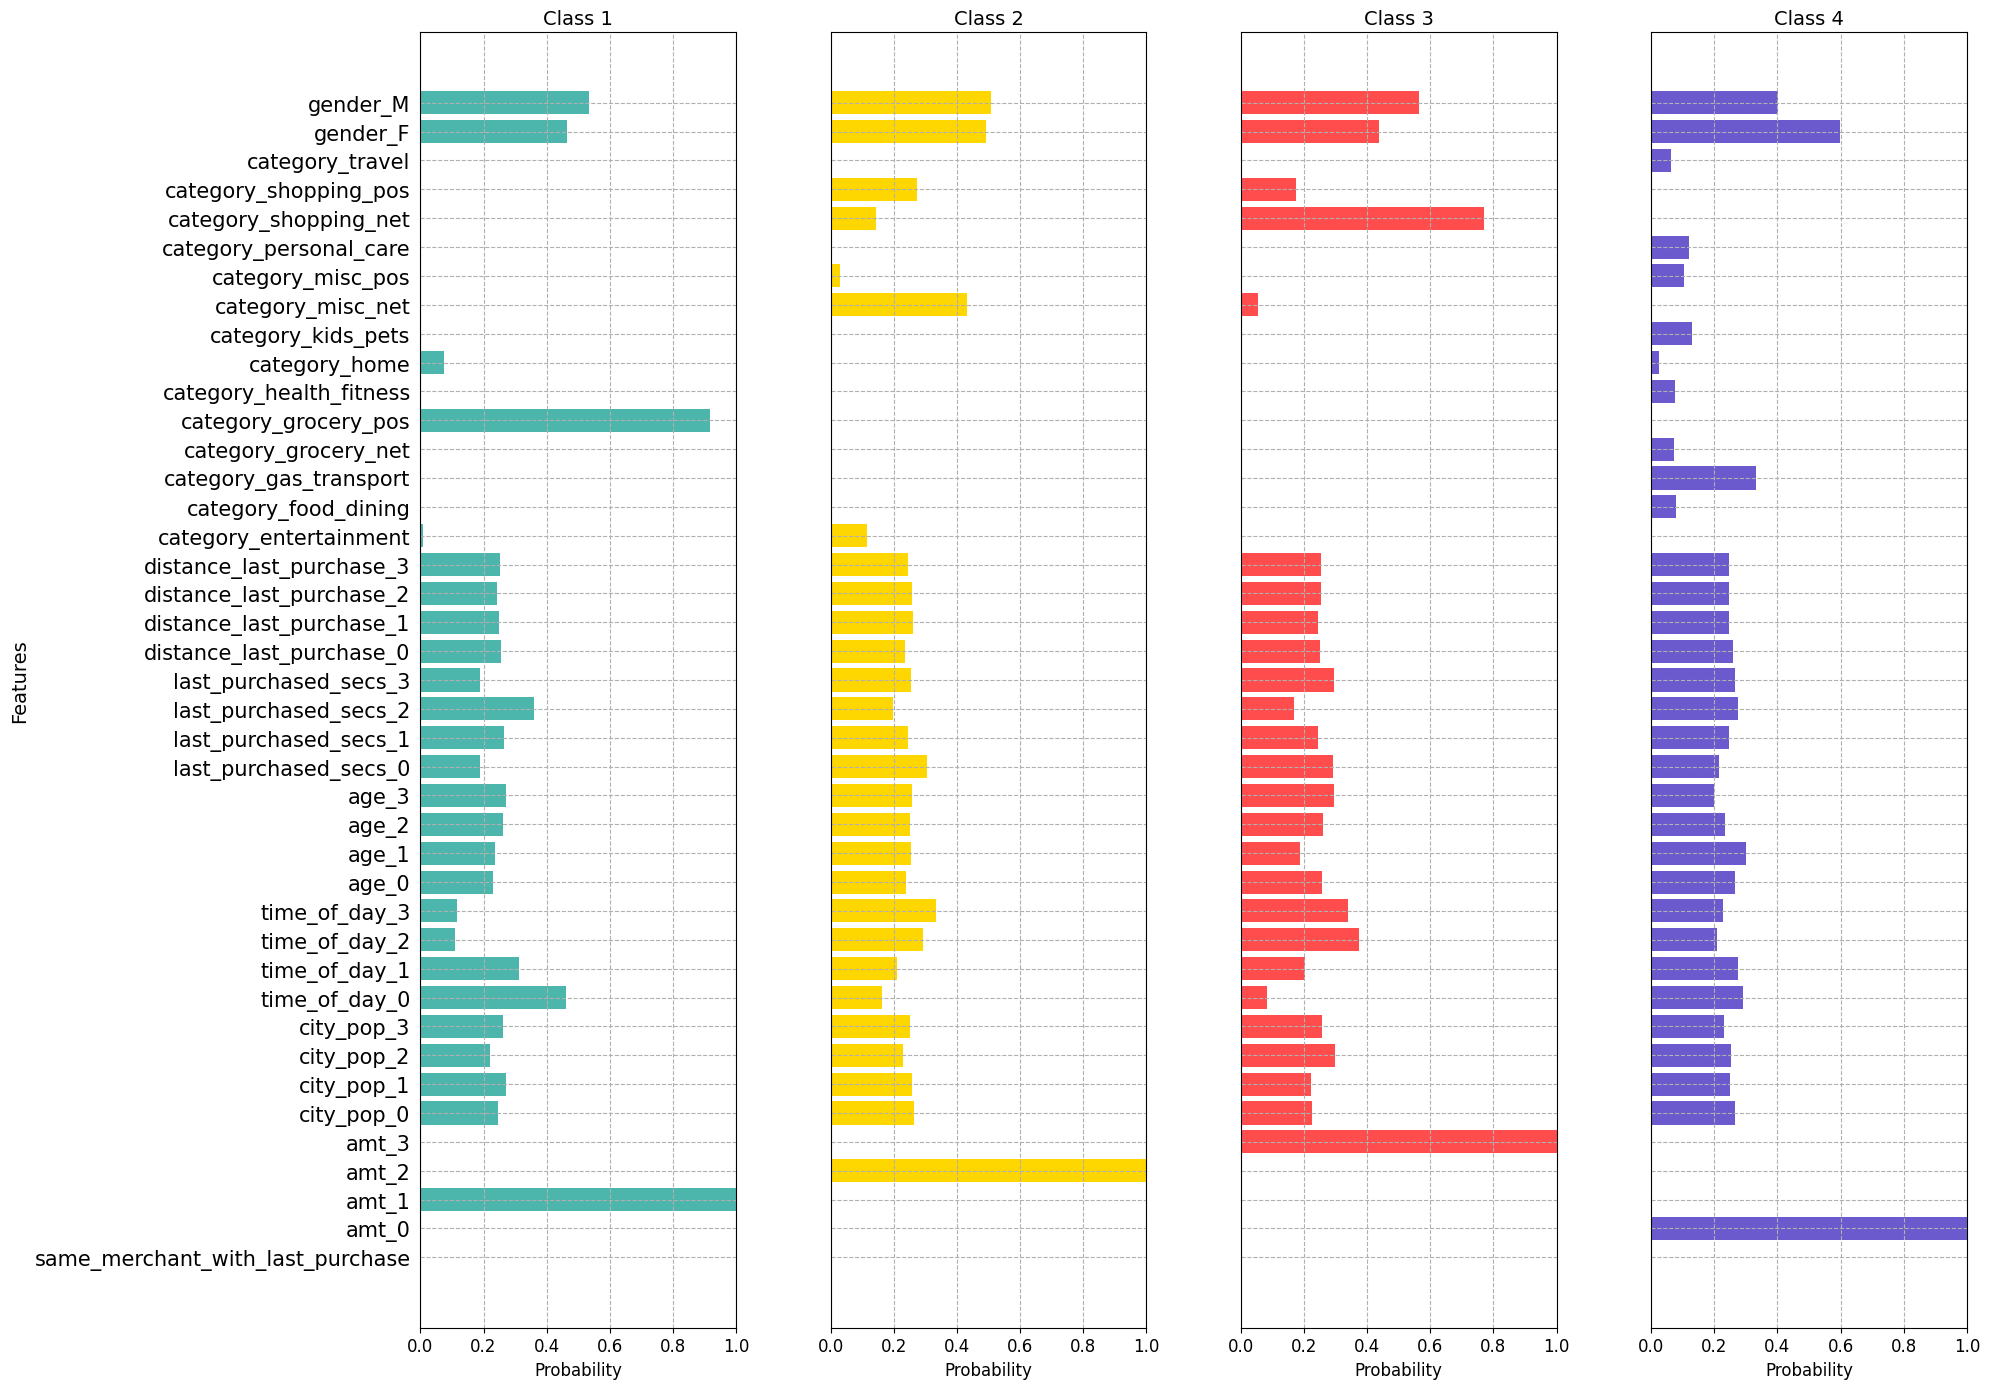

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels (assuming n_components latent classes)
n_classes = class_probabilities.shape[0]
class_labels = [f"Class {i+1}" for i in range(n_classes)]

# Define plot layout
fig, axs = plt.subplots(1, n_classes, figsize=(20, 14), sharey=True)

# Set x-axis limit to ensure all plots have the same scale
x_limit = 1.0

# Define colors for each class
colors = ["#4DB6AC", "#FFD700", "#FF4D4D", "#6A5ACD", "#FF8C00"][:n_classes]  # Extend if more classes exist

# Plot each latent class
for i in range(n_classes):
    axs[i].barh(class_probabilities.columns, class_probabilities.iloc[i], color=colors[i])
    axs[i].set_title(class_labels[i], fontsize=14)
    axs[i].tick_params(left=False)
    axs[i].set_xlim(0, x_limit)

# Set y-axis labels for all subplots
axs[0].set_ylabel("Features", fontsize=14)
axs[0].set_yticks(range(len(class_probabilities.columns)))
axs[0].set_yticklabels(class_probabilities.columns, fontsize=15)

# Set x-axis labels
for ax in axs:
    ax.set_xlabel("Probability", fontsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.set_facecolor('none')
    ax.grid(linestyle="--")

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()


Based on the membership probabilities, we define 4 types of fraud:
